# Churn Prediction

Entender o motivo pelo qual os seus clientes param de adquirir o seu produto ou serviço é algo essencial para que o negócio se mantenha saudável, lucrativo e para que faça sucesso. É necessário que o número de novos clientes seja maior do que a taxa de clientes que cancelaram, chamada de Churn Rate. Para calcularmos esta taxa, basta dividirmos o número total de clientes desistentes pelo número total de clientes ativos do último mês. 
Podemos também calcular o MRR Churn, que é referente à receita do negócio, dividindo a soma dos valores que os clientes que cancelaram pagavam pela soma dos valores pagos por todos os clientes ativos no último mês.

Como o custo de aquisição de um novo cliente é mais alto do que para manter um já existente, identificar possíveis cancelamentos previamente e adotar medidas para evitá-los é algo de extrema importância para um negócio.

Neste projeto, com a utilização de algoritmos de Machine Learning, iremos construir um modelo para, a partir de dados que o modelo criado não conhece, identificarmos quantas vezes detectaremos corretamente que um cliente cancelou a sua assinatura.

## Aquisição dos Dados

Os dados que usaremos neste projeto foram originalmente disponibilizados na plataforma de ensino da [IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O conjunto de dados completo pode ser obtido no [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn/data).

Começaremos importando as bibliotecas e os dados que utilizaremos.

In [1]:
# importando as bibliotecas necessárias

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set_style('dark')

In [2]:
# importando os dados para um dataframe

url = "datasets/churn.csv"
df = pd.read_csv(url)

Após importarmos os dados para um dataframe, vamos visualizar as 5 primeiras entradas do conjunto de dados.

In [3]:
# visualizando as 5 primeiras entradas

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Análise Exploratória dos Dados

Começaremos a análise visualizando os nomes das colunas e seus tipos de dados, além da quantidade de linhas e colunas do conjunto de dados. 

In [4]:
# visualizando os nomes e os tipos de dados das colunas do dataframe

df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# obtendo a quantidade de linhas e colunas do dataframe

df.shape

(7043, 21)

Como podemos ver, o nosso dataframe possui 7043 linhas e 21 colunas. A fim de identificarmos possíveis variáveis categóricas, iremos obter a quantidade de valores únicos por coluna.

In [6]:
# obtendo a quantidade de valores diferentes por coluna

df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Vamos verificar se o conjunto de dados possui valores faltantes.

In [7]:
# verificando se há valores faltantes

df.isnull().sum().values.sum()

0

Como vimos anteriormente, cada linha do dataframe representa um cliente e cada coluna contém informações referentes à assinatura realizada pelo cliente. Pudemos ver também que a coluna 'TotalCharges', que é referente ao valor total que já foi cobrado ao cliente, está no formato 'object', apesar de ser um valor numérico. Portanto, para podermos trabalhar com estes dados numéricos, converteremos a coluna para o tipo de dado 'float'. Criaremos uma função para esta conversão.

In [8]:
# criando uma função para converter os valores

def str_to_float(value):
    
    try:
        return float(value)
    except ValueError:
        return np.nan
    
# convertendo os valores utilizando a função

df_clean = df.copy()
df_clean['TotalCharges'] = df_clean['TotalCharges'].apply(str_to_float)

Após a conversão, vamos verificar se houve tentativa de converter algum valor não numérico em numérico. Se identificada, aplicaremos a mediana de todos os valores numéricos da coluna para estes valores não numéricos.

In [9]:
# verificando se há valores não numéricos na coluna 'TotalCharges'

df_clean['TotalCharges'].isnull().sum()

11

In [10]:
# salvando a mediana dos valores da coluna 'TotalCharges'

totalChargesMedian = df_clean['TotalCharges'].median()

# preenchendo os valores não numéricos com a mediana

df_clean['TotalCharges'].fillna(totalChargesMedian, inplace = True)

Feito isso, apagaremos a coluna 'costumerID' pois não a utilizaremos para esta análise.

In [11]:
# removendo a coluna 'costumerID'

df_clean.drop('customerID', axis = 1, inplace = True)

Agora, iremos olhar quais são os valores que estão contidos em algumas das colunas, referentes a serviços, que informam se o cliente adquiriu ou não um serviço em específico.

In [12]:
# obtendo os valores da coluna 'OnlineSecurity'

df_clean['OnlineSecurity'].value_counts()

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

In [13]:
# obtendo os valores da coluna 'OnlineBackup'

df_clean['OnlineBackup'].value_counts()

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

In [14]:
# obtendo os valores da coluna 'DeviceProtection'

df_clean['DeviceProtection'].value_counts()

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

In [15]:
# obtendo os valores da coluna 'TechSupport'

df_clean['TechSupport'].value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

In [16]:
# obtendo os valores da coluna 'StreamingTV'

df_clean['StreamingTV'].value_counts()

No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64

In [17]:
# obtendo os valores da coluna 'StreamingMovies'

df_clean['StreamingMovies'].value_counts()

No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64

Assumindo a premissa de que os clientes que não possuem o serviço de internet também não possuem um serviço em específico, substituiremos os valores 'No internet service' por 'No' das colunas acima analisadas.

In [18]:
# substituindo 'No internet service' por 'No' das colunas definidas

col_names = ['OnlineSecurity', \
             'OnlineBackup', \
             'DeviceProtection', \
             'TechSupport', \
             'StreamingTV', \
             'StreamingMovies']

for i in col_names:
    df_clean[i] = df_clean[i].replace({'No internet service' : 'No'})

A coluna 'tenure' é referente ao número de meses em que o cliente contratou o serviço. A fim de inserirmos uma nova coluna categórica, criaremos uma coluna com faixas temporais de permanência no serviço. Para isto, criaremos uma nova função.

In [19]:
# criando uma função para classificação por faixa temporal

def set_tenure_category(v):
    
    if (v <= 12):
        return 'Tenure_0-12'
    elif (v > 12) & (v <= 24):
        return 'Tenure_13-24'
    elif (v > 24) & (v <= 48):
        return 'Tenure_25-48'
    elif (v > 48) & (v <= 60):
        return 'Tenure_49-60'
    elif (v > 60):
        return 'Tenure_qt_60'

In [20]:
# criando uma nova coluna com os valores por faixa

df_clean['tenure_group'] = df_clean['tenure'].apply(set_tenure_category)

Este conjunto de dados é composto majoritariamente por variáveis binárias ou categóricas, e é possível ver abaixo, pelo método describe, que não há indícios da presença de outliers.

In [21]:
# obtendo um resumo estatístico

df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Confirmando a ausência de outliers:

In [22]:
# aplicando o cálculo do 1.5 x IQR na coluna 'TotalCharges'

Q1 = df_clean['TotalCharges'].quantile(q = 0.25)
Q3 = df_clean['TotalCharges'].quantile(q = 0.75)

IQR = Q3 - Q1
print(Q3 + 1.5 * IQR)
print(Q1 - 1.5 * IQR)

8863.1625
-4674.3375


In [23]:
# aplicando o cálculo do 1.5 x IQR na coluna 'MonthlyCharges'

Q1 = df_clean['MonthlyCharges'].quantile(q = 0.25)
Q3 = df_clean['MonthlyCharges'].quantile(q = 0.75)

IQR = Q3 - Q1
print(Q3 + 1.5 * IQR)
print(Q1 - 1.5 * IQR)

171.375
-46.02499999999999


Enfim, plotaremos gráficos de caixa para as colunas 'MonthlyCharges' e 'TotalCharges'.

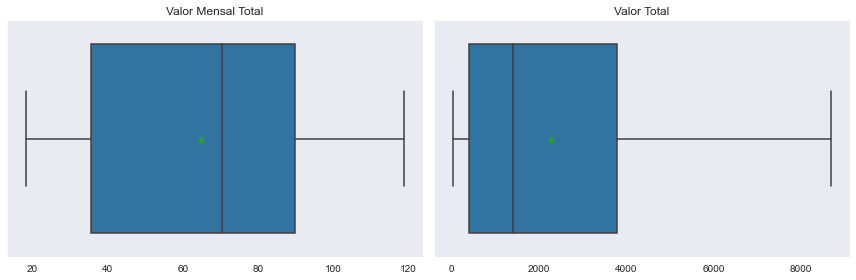

In [24]:
# plotando boxplots para as colunas 'MonthlyCharges' e 'TotalCharges'

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
sns.boxplot(df_clean['MonthlyCharges'], ax = ax[0], showmeans = True)
sns.boxplot(df_clean['TotalCharges'], ax = ax[1], showmeans = True)
ax[0].set_title('Valor Mensal Total')
ax[1].set_title('Valor Total')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.tight_layout()

## Visualização de dados

Veremos agora, gerando gráficos, quais informações podemos obter a partir do conjunto de dados.

No gráfico de distribuição abaixo, podemos ver a distribuição dos valores pagos mensalmente pelos clientes.

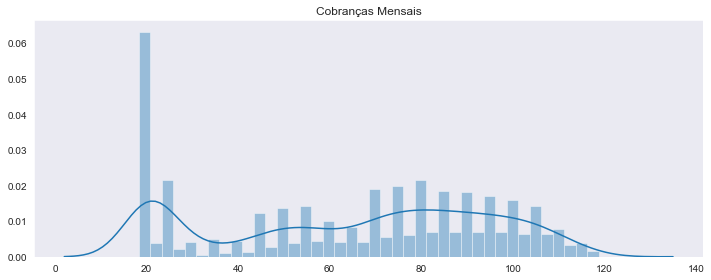

In [25]:
# gerando um gráfico de distribuição para a coluna 'MonthlyCharges'

fig, ax = plt.subplots(figsize = (10, 4))
sns.distplot(df_clean['MonthlyCharges'], ax = ax, bins = 40)
ax.set_xlabel('')
ax.set_title('Cobranças Mensais')
plt.tight_layout()

Já neste outro gráfico, podemos ver a distribuição de todos os valores pagos pelos clientes.

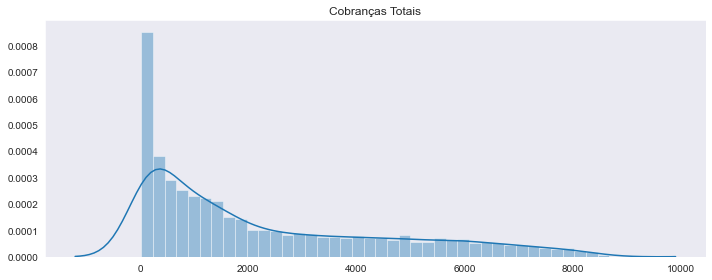

In [26]:
# gerando um gráfico de distribuição para a coluna 'TotalCharges'

fig, ax = plt.subplots(figsize = (10, 4))
sns.distplot(df_clean['TotalCharges'], ax = ax, bins = 40)
ax.set_xlabel('')
ax.set_title('Cobranças Totais')
plt.tight_layout()

Agora, gerando um gráfico de barras, podemos ver que, dentre as faixas temporais de permanência no serviço criadas para esta análise, aquelas com mais clientes registrados foram 'Entre 0 a 12 meses' e 'Entre 25 e 48 meses'.

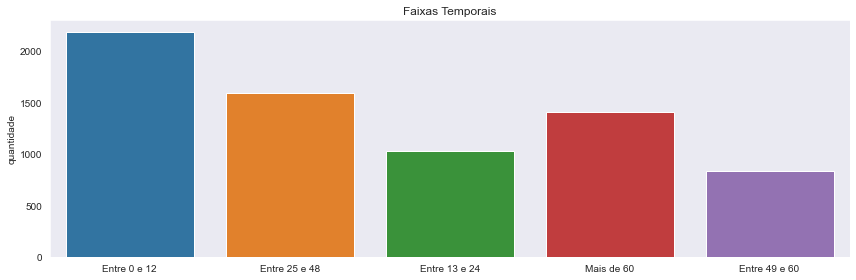

In [27]:
# gerando um gráfico de barras da coluna 'tenure_group'

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title('Faixas Temporais')
sns.countplot(df_clean['tenure_group'], ax = ax)
ax.set_xticklabels(('Entre 0 e 12', 'Entre 25 e 48', 'Entre 13 e 24', 'Mais de 60', 'Entre 49 e 60'))
ax.set_xlabel('')
ax.set_ylabel('quantidade')
plt.tight_layout()

Neste outro gráfico de barras podemos ver que o tipo de contrato mais assinado foi o de assinatura mensal.

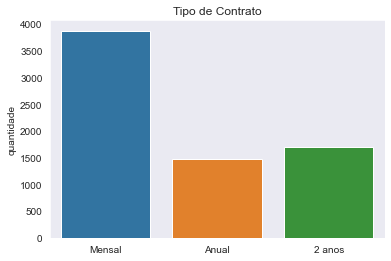

In [28]:
# gerando um gráfico de barras da coluna 'Contract'

fig, ax = plt.subplots()
ax.set_title('Tipo de Contrato')
sns.countplot('Contract', data = df_clean, ax = ax)
ax.set_xticklabels(('Mensal', 'Anual', '2 anos'))
ax.set_xlabel('')
ax.set_ylabel('quantidade')
plt.show()

Vemos também que a forma de pagamento mais utilizado foi a de 'Electronic check'.

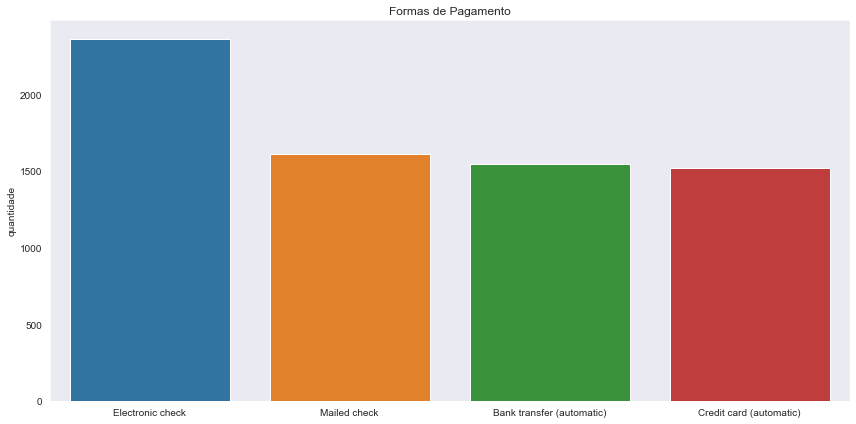

In [29]:
# gráfico de barras da coluna 'PaymentMethod'

fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title('Formas de Pagamento')
sns.countplot('PaymentMethod', data = df_clean, ax = ax)
ax.set_xlabel('')
ax.set_ylabel('quantidade')
plt.tight_layout()

Gerando mais dois gráficos de barras, podemos ver que a porcentagem de clientes idosos é muito baixa em relação a de não idosos. Já quanto ao gênero, podemos ver que a diferença é mínima, com uma pequena vantagem no número de clientes do sexo masculino.

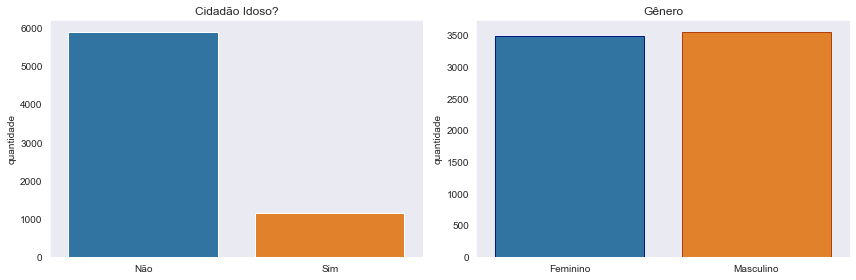

In [30]:
# gerando gráficos de barras das colunas 'SeniorCitizen' e 'gender'

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

ax[0].set_title('Cidadão Idoso?')
sns.countplot('SeniorCitizen', data = df_clean, ax = ax[0])
ax[0].set_xticklabels(('Não', 'Sim'))
ax[0].set_xlabel('')
ax[0].set_ylabel('quantidade')

ax[1].set_title('Gênero')
sns.countplot('gender', data = df_clean, ax = ax[1], edgecolor = sns.color_palette('dark', 3))
ax[1].set_xticklabels(('Feminino', 'Masculino'))
ax[1].set_xlabel('')
ax[1].set_ylabel('quantidade')

plt.tight_layout()

Plotaremos gráficos de barras para as colunas em que alteramos anteriormente o valor 'No internet service' para 'No'.

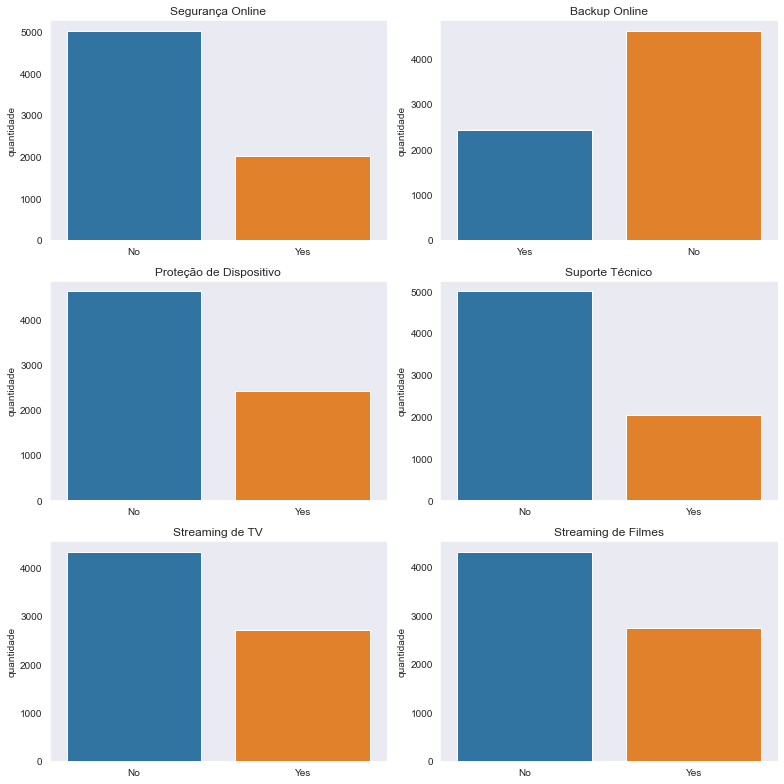

In [31]:
# gerando gráficos de barras para as colunas definidas

column_names = 'OnlineSecurity', \
               'OnlineBackup', \
               'DeviceProtection', \
               'TechSupport', \
               'StreamingTV', \
               'StreamingMovies'

column_names_pt = 'Segurança Online', \
                  'Backup Online', \
                  'Proteção de Dispositivo', \
                  'Suporte Técnico', \
                  'Streaming de TV', \
                  'Streaming de Filmes'

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (11,11))
fig.subplots_adjust(hspace = 1, wspace = 1)

ind = 0
for col, col_pt in zip(column_names, column_names_pt):
    ind += 1
    plt.subplot(3, 2, ind)
    sns.countplot(df_clean[col])
    plt.title(col_pt)
    plt.ylabel('quantidade')
    plt.xlabel('')
plt.tight_layout()

### Churn

Neste conjunto de dados, a coluna 'Churn' indica quando um cliente cancelou a sua assinatura com a operadora de telecomunicação. Veremos agora a quantidade de clientes que cancelaram e a de clientes que continuam com a assinatura.

In [32]:
# obtendo a porcentagem de 'Yes' e 'No' da coluna 'Churn'

print(round((df_clean.Churn.value_counts() / df_clean.shape[0]) * 100, 2))

No     73.46
Yes    26.54
Name: Churn, dtype: float64


Como vimos, 26,54% dos clientes registrados nos dados que estamos analisando cancelaram as suas assinaturas. Plotaremos um gráfico de barras para vermos graficamente essa informação.

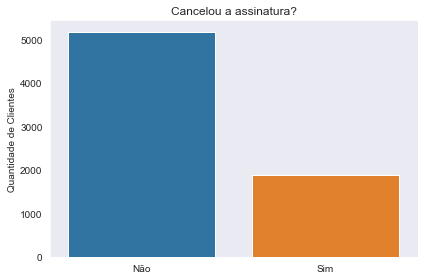

In [33]:
# plotando um gráfico de barras da coluna 'Churn'

fig, ax = plt.subplots()
ax.set_title('Cancelou a assinatura?')
sns.countplot('Churn', data = df_clean, ax = ax)
ax.set_xticklabels(('Não', 'Sim'))
ax.set_xlabel('')
ax.set_ylabel('Quantidade de Clientes')

plt.tight_layout()

## Preparação dos Dados

Nesta etapa de preparação dos dados, realizaremos um pré-processamento básico, apenas com a finalidade de construirmos um modelo base. Separaremos as colunas com tipos de dados numéricos das com tipos de dados categóricos.

In [34]:
# obtendo as colunas categóricas que possuem 2 valores diferentes

binary_cols = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()

# obtendo as colunas numéricas

num_cols = [c for c in df_clean.select_dtypes(['int', 'float']).columns.tolist() if c not in binary_cols]

# obtendo as colunas categóricas restantes

cat_cols = [c for c in df_clean.columns.tolist() if c not in binary_cols + num_cols]

Os valores das colunas categóricas serão transformadas em variáveis 'dummy', ou seja, cada valor registrado para essas colunas virará uma nova coluna, contendo como valor 0 ou 1. As colunas que contêm apenas dois tipos diferentes de valores serão processadas usando o 'LabelEncoder', transformando os valores em 0 e 1.

In [35]:
# aplicando o 'LabelEncoder' e obtendo as variáveis 'dummy' 

df_proc = df_clean.copy()

lblencoder = LabelEncoder()
for b in binary_cols:
    df_proc[b] = lblencoder.fit_transform(df_proc[b])
    
df_proc = pd.get_dummies(df_proc, columns = cat_cols)

Visualizaremos agora as 5 primeiras entradas do dataframe após as modificações.

In [36]:
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_0-12,tenure_group_Tenure_13-24,tenure_group_Tenure_25-48,tenure_group_Tenure_49-60,tenure_group_Tenure_qt_60
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,1,0,0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,1,0,0,0,0,1,0,1,1,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


## Modelo de Machine Learning

Falando de Churn, se detectarmos um cliente, que não iria cancelar, como sendo um potencial cliente cancelando a assinatura, o máximo que vai acontecer é que será enviado um e-mail para ele ou até mesmo presenteado um mês de assinatura e, por muitas vezes o cliente nem vai descobrir que foi tomada uma medida para evitar o potencial cancelamento que não ocorreria.

Se estivéssemos falando de um problema diferente, como a detecção de fraude ou não em um cartão de crédito e seu subsequente bloqueio, provavelmente teríamos que pensar diferente, pois a probabilidade de perder um cliente que tem o seu cartão bloqueado, sendo que não houve uma fraude verdadeira, é muito grande.

Partindo da premissa que, para esta análise, queremos que nosso modelo detecte quando houve um cancelamento de uma assinatura, utilizaremos a métrica de avaliação 'Recall', que é utilizada para modelos de classificação.

Separaremos a coluna alvo 'Churn' das demais do conjunto de dados.

In [37]:
# separando a coluna alvo 'Churn' das demais

X = df_proc.drop('Churn', axis = 1)
y = df_proc['Churn']

A taxa de treino e teste pode ser algo como 80/20, 75/25, etc. Essa é uma decisão que precisamos tomar com base na quantidade de dados. Antes de avançarmos para o balanceamento dos dados, vamos dividi-los em dados de treino e de teste.

Na função 'train_test_split' que utilizaremos, podemos definir alguns parâmetros. O parâmetro 'shuffle' será definido como 'True'; portanto, o conjunto de dados será embaralhado aleatoriamente antes da divisão. 
Utilizaremos também o parâmetro 'stratify', que é essencial ao lidar com conjuntos de dados desequilibrados. Ele faz uma divisão para que a proporção dos valores na amostra produzida seja a mesma que a proporção dos valores fornecidos ao parâmetro 'stratify'. Por exemplo, se a variável 'y' for uma variável categórica binária com valores 0 e 1 e houver 10% de zeros e 90% de uns, 'stratify' = y garantirá que sua divisão aleatória tenha 10% de 0 e 90% de 1.

In [38]:
# dividindo os dados em dados de treino e dados de teste

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle = True, \
                                                    test_size = 0.25, random_state = 42)

Usaremos cross-validation para avaliarmos o nosso modelo, utilizando somente os dados de treino e obtendo o 'Recall'. Lembramos que essa validação é necessária para que tenhamos certeza que o modelo escolhido é o melhor possível.
Criaremos uma função para a realização do cross-validation e, inicialmente, validaremos os dados de treino que ainda não sofreram nenhum tipo de alteração, como padronização ou balanceamento.

In [39]:
# criando uma função para a validação do modelo

def val_model(X, y, clf, quite = False):
    
    X = np.array(X)
    y = np.array(y)
    
    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring = 'recall')
    
    if quite == False:
        print('scores: ', scores)
        print('Recall: {:.2f} (+/- {:.2f})'.format(scores.mean(), scores.std()))
        
    return scores.mean()

Para esta primeira validação, usaremos o algoritmo de Machine Learning 'Random Forest' sem nenhum ajuste de parâmetro.

In [40]:
# validando o modelo

rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

scores:  [0.42348754 0.52669039 0.46785714 0.44285714 0.50714286]
Recall: 0.47 (+/- 0.04)


Como podemos ver, obtivemos um Recall de 0.47 e um desvio-padrão de 0.04, o que significa que este modelo detectou em torno de 47% das vezes que realmente seriam 'Churn'. A confiabilidade dessa informação é de 95%. Iremos agora padronizar nossos dados.

In [41]:
# padronizando os valores de 'X_train'

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

Iremos, também, realizar o balanceamento dos dados. Como o conjunto de dados possui um desequilíbrio nos valores da coluna alvo 'Churn', iremos balancear os dados priorizando os valores que estão em minoria, ou seja, que informam quando houve 'Churn'. Utilizaremos a técnica de Undersampling nos dados de treino.

In [42]:
# balanceando os dados utilizando 'Undersampling' e preservando a classe minoritária

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

y_train_rus.value_counts()

1    1402
0    1402
Name: Churn, dtype: int64

Após a utilização da técnica, podemos ver que agora possuímos a mesma quantidade de valores 0 e 1 na coluna 'Churn'.

Aplicaremos agora a cross-validation a vários modelos a fim de identificarmos os seus desempenhos e escolher o(s) melhor(es). Novamente, serão utilizados apenas dados de treino.

In [43]:
# instanciando os modelos

rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []

# avaliando o desempenho (recall)

for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite = True))
    
pd.DataFrame(data = recall, index = model, columns = ['Recall'])

,Recall
RandomForestClassifier,0.755371
DecisionTreeClassifier,0.676899
SGDClassifier,0.716817
SVC,0.771746
LogisticRegression,0.782448
XGBClassifier,0.755346
LGBMClassifier,0.770343


Como podemos ver, o Recall mais alto que obtivemos foi utilizando o 'LogisticRegression', porém tivemos um bom desempenho com outros algoritmos também. Usaremos o 'XGBClassifier' pela possibilidade de melhorarmos consideravelmente o nosso 'Recall' através da escolha dos melhores parâmetros.

O primeiro parâmetro em que iremos procurar o melhor resultado é o 'n_estimators'.

In [44]:
# definindo o parâmetro

xgb = XGBClassifier(learning_rate = 0.1)

param_grid = { 'n_estimators' : range(0, 1000, 50), }

# identificando o melhor parâmetro

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(xgb, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# vendo os resultados

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7845795339412361 para {'n_estimators': 50}


Agora, procuraremos os melhores resultados para os parâmetros 'max_depth' e 'min_child_weight'. 

In [45]:
# definindo o parâmetro

xgb = XGBClassifier(learning_rate = 0.1, n_estimators = 50)

param_grid = {
    'max_depth' : range(1, 8, 1),
    'min_child_weight' : range(1, 5, 1)
}

# identificando o melhor parâmetro

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(xgb, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# vendo os resultados

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8344934143870315 para {'max_depth': 1, 'min_child_weight': 1}


Agora identificaremos os melhores resultados para 'gamma'.

In [46]:
# definindo o parâmetro

xgb = XGBClassifier(learning_rate = 0.1, n_estimators = 50, max_depth = 1, min_child_weight = 1)

param_grid = {
    'gamma' : [i / 10.0 for i in range(0, 5)]
}

# identificando o melhor parâmetro

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(xgb, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# vendo os resultados

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8345390070921985 para {'gamma': 0.0}


E, por último, os melhores para 'learning_rate'.

In [47]:
# definindo o parâmetro

xgb = XGBClassifier(n_estimators = 50, max_depth = 1, min_child_weight = 1, gamma = 0.0)

param_grid = {
    'learning_rate' : [0.001, 0.01, 0.1, 1]
}

# identificando o melhor parâmetro

kfold = StratifiedKFold(n_splits = 10, shuffle = True)
grid_search = GridSearchCV(xgb, param_grid, scoring = "recall", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# vendo os resultados

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.88516210739615 para {'learning_rate': 0.001}


Agora que identificamos os melhores parâmetros, ou seja, aqueles que resultaram em um 'Recall' mais alto, iremos padronizar os dados de teste e predizer em cima do modelo que obtivemos os melhores resultados.

In [48]:
# modelo final

xgb = XGBClassifier(learning_rate = 0.001, n_estimators = 50, max_depth = 1, min_child_weight = 1, gamma = 0.0)
xgb.fit(X_train_rus, y_train_rus)

# fazendo a predição

X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

Gerando um 'Classification Report', podemos ver o resultado das métricas de classificação de acordo com o nosso modelo.

In [49]:
# gerando um Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      1294
           1       0.43      0.89      0.58       467

    accuracy                           0.66      1761
   macro avg       0.68      0.73      0.64      1761
weighted avg       0.80      0.66      0.67      1761



Observando o 'Recall' podemos ver que o modelo acertou 89% das vezes em que de fato era 'Churn'. Plotaremos agora uma matriz de confusão que nos mostra que 0.57 da vezes que de fato não era 'Churn' nosso modelo detectou como não sendo e que 0.89 da vezes que era nosso modelo realmente acertou que era.

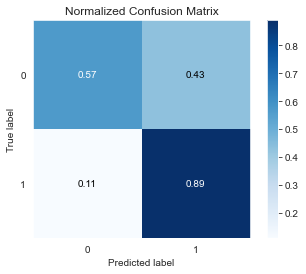

In [50]:
# plotando uma matriz de confusão

plot_confusion_matrix(y_test, y_pred, normalize = True)
plt.show()

### Conclusão

Para este projeto, escolhemos somente observar a métrica 'Recall'. Utilizamos o classificador 'XGBClassifier' pois possui vários parâmetros que nos possibilitam melhorar consideravelmente o valor obtido através da métrica escolhida. Se obtivermos um novo conjunto de dados e necessitarmos realizar a predição para sabermos se um cliente pode vir a cancelar a sua assinatura, basta utilizarmos o modelo que criamos, validamos e testamos.